In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import holidays
pd.options.display.max_columns=100
import warnings
warnings.filterwarnings('ignore')

In [2]:
## Evaluation metrics
def mean_absolute_percentage_error(y_true, y_pred, breakdown=False):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if breakdown:
        mape = (np.abs((y_true - y_pred) / y_true)) * 100
    else:
        mape = np.mean((np.abs((y_true - y_pred) / y_true)) * 100)
    return mape

def MdAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mdape = np.median(np.abs((y_true - y_pred) / y_true)) * 100
    return mdape

## Stationarity Test
def adf_test(series,title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag=None,maxlag=12)
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
    return out


def calendar_holidays():
    us_holidays = []
    yrs = list(range(2014, 2026))

    for yr in yrs:
        for date, name in sorted(holidays.US(years=yr).items()):
            us_holidays.append([pd.to_datetime(date), name])

    us_holidays = pd.DataFrame(us_holidays)
    us_holidays.columns = ['ds', 'holiday']
    us_holidays = us_holidays.drop_duplicates(subset=['ds'])

    # Update observed dates for specific holidays
    observed_dates = {
        pd.to_datetime('2014-02-01'): 'Superbowl (Observed)',
        pd.to_datetime('2014-02-02'): 'Superbowl',
        pd.to_datetime('2015-01-31'): 'Superbowl (Observed)',
        pd.to_datetime('2015-02-01'): 'Superbowl',
        pd.to_datetime('2016-02-06'): 'Superbowl (Observed)',
        pd.to_datetime('2016-02-07'): 'Superbowl',
        pd.to_datetime('2017-02-04'): 'Superbowl (Observed)',
        pd.to_datetime('2017-02-05'): 'Superbowl',
        pd.to_datetime('2018-02-03'): 'Superbowl (Observed)',
        pd.to_datetime('2018-02-04'): 'Superbowl',
        pd.to_datetime('2019-02-02'): 'Superbowl (Observed)',
        pd.to_datetime('2019-02-03'): 'Superbowl',
        pd.to_datetime('2020-02-01'): 'Superbowl (Observed)',
        pd.to_datetime('2020-02-02'): 'Superbowl',
        pd.to_datetime('2021-02-06'): 'Superbowl (Observed)',
        pd.to_datetime('2021-02-07'): 'Superbowl',
        pd.to_datetime('2022-02-05'): 'Superbowl (Observed)',
        pd.to_datetime('2022-02-06'): 'Superbowl',
        pd.to_datetime('2023-02-04'): 'Superbowl (Observed)',
        pd.to_datetime('2023-02-05'): 'Superbowl',
        pd.to_datetime('2024-02-03'): 'Superbowl (Observed)',
        pd.to_datetime('2024-02-04'): 'Superbowl',
        pd.to_datetime('2025-02-01'): 'Superbowl (Observed)',
        pd.to_datetime('2025-02-02'): 'Superbowl',
        
        pd.to_datetime('2014-02-14'): 'Valentines',
        pd.to_datetime('2015-02-14'): 'Valentines',
        pd.to_datetime('2016-02-14'): 'Valentines',
        pd.to_datetime('2017-02-14'): 'Valentines',
        pd.to_datetime('2018-02-14'): 'Valentines',
        pd.to_datetime('2019-02-14'): 'Valentines',
        pd.to_datetime('2020-02-14'): 'Valentines',
        pd.to_datetime('2021-02-14'): 'Valentines',
        pd.to_datetime('2022-02-14'): 'Valentines',
        pd.to_datetime('2023-02-14'): 'Valentines',
        pd.to_datetime('2024-02-14'): 'Valentines',
        pd.to_datetime('2025-02-14'): 'Valentines',
        
        pd.to_datetime('2014-05-10'): 'Mothers Day (Observed)',
        pd.to_datetime('2014-05-11'): 'Mothers Day',
        pd.to_datetime('2015-05-09'): 'Mothers Day (Observed)',
        pd.to_datetime('2015-05-10'): 'Mothers Day',
        pd.to_datetime('2016-05-07'): 'Mothers Day (Observed)',
        pd.to_datetime('2016-05-08'): 'Mothers Day',
        pd.to_datetime('2017-05-13'): 'Mothers Day (Observed)',
        pd.to_datetime('2017-05-14'): 'Mothers Day',
        pd.to_datetime('2018-05-12'): 'Mothers Day (Observed)',
        pd.to_datetime('2018-05-13'): 'Mothers Day',
        pd.to_datetime('2019-05-11'): 'Mothers Day (Observed)',
        pd.to_datetime('2019-05-12'): 'Mothers Day',
        pd.to_datetime('2020-05-09'): 'Mothers Day (Observed)',
        pd.to_datetime('2020-05-10'): 'Mothers Day',
        pd.to_datetime('2021-05-08'): 'Mothers Day (Observed)',
        pd.to_datetime('2021-05-09'): 'Mothers Day',
        pd.to_datetime('2022-05-07'): 'Mothers Day (Observed)',
        pd.to_datetime('2022-05-08'): 'Mothers Day',
        pd.to_datetime('2023-05-13'): 'Mothers Day (Observed)',
        pd.to_datetime('2023-05-14'): 'Mothers Day',
        pd.to_datetime('2024-05-11'): 'Mothers Day (Observed)',
        pd.to_datetime('2024-05-12'): 'Mothers Day',
        pd.to_datetime('2025-05-10'): 'Mothers Day (Observed)',
        pd.to_datetime('2025-05-11'): 'Mothers Day',
        
        pd.to_datetime('2014-04-19'): 'Easter (Observed)',
        pd.to_datetime('2014-04-20'): 'Easter',
        pd.to_datetime('2015-04-04'): 'Easter (Observed)',
        pd.to_datetime('2015-04-05'): 'Easter',
        pd.to_datetime('2016-03-26'): 'Easter (Observed)',
        pd.to_datetime('2016-03-27'): 'Easter',
        pd.to_datetime('2017-04-15'): 'Easter (Observed)',
        pd.to_datetime('2017-04-16'): 'Easter',
        pd.to_datetime('2018-03-31'): 'Easter (Observed)',
        pd.to_datetime('2018-04-01'): 'Easter',
        pd.to_datetime('2019-04-20'): 'Easter (Observed)',
        pd.to_datetime('2019-04-21'): 'Easter',
        pd.to_datetime('2020-04-11'): 'Easter (Observed)',
        pd.to_datetime('2020-04-12'): 'Easter',
        pd.to_datetime('2021-04-03'): 'Easter (Observed)',
        pd.to_datetime('2021-04-04'): 'Easter',
        pd.to_datetime('2022-04-16'): 'Easter (Observed)',
        pd.to_datetime('2022-04-17'): 'Easter',
        pd.to_datetime('2023-04-08'): 'Easter (Observed)',
        pd.to_datetime('2023-04-09'): 'Easter',
        pd.to_datetime('2024-03-30'): 'Easter (Observed)',
        pd.to_datetime('2024-03-31'): 'Easter',
        pd.to_datetime('2025-04-19'): 'Easter (Observed)',
        pd.to_datetime('2025-04-20'): 'Easter',
    }

    us_holidays['holiday'].update(pd.Series(observed_dates))

    us_holidays = us_holidays.set_index('ds')
    us_holidays = us_holidays.sort_index()

    us_holidays = us_holidays.reset_index().reset_index(drop=True)

    return us_holidays

In [3]:
sale = pd.read_csv('train.csv')
features = pd.read_csv('features.csv')

sale['Date'] = pd.to_datetime(sale['Date'])
features['Date'] = pd.to_datetime(features['Date'])

## Inner Join Sale and Feature Data on Store number and Date
df = pd.merge(sale,features,on=['Store','Date'])
df = df[['Store','Dept','Date',
         'Weekly_Sales','IsHoliday_x',
         'Temperature','Fuel_Price',
         'CPI','Unemployment']]

## Convert Raw Date to Year, Month and Week
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week 

df['Date'] = pd.to_datetime(df['Date'])
df.set_index(keys=['Date'], inplace=True)

In [4]:
df.head()

,Store,Dept,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week
Date,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,42.31,2.572,211.096358,8.106,2010,2,5
2010-02-05,1,2,50605.27,False,42.31,2.572,211.096358,8.106,2010,2,5
2010-02-05,1,3,13740.12,False,42.31,2.572,211.096358,8.106,2010,2,5
2010-02-05,1,4,39954.04,False,42.31,2.572,211.096358,8.106,2010,2,5
2010-02-05,1,5,32229.38,False,42.31,2.572,211.096358,8.106,2010,2,5


In [5]:
print('Start dt:', df.index.min())
print('End dt:', df.index.max())
print('Total weeks: %d'%int((df.index.max() - df.index.min()) / np.timedelta64(1, 'W')))
print('\nTotal stores: %d'%(len(df['Store'].unique())))
print('Total dept: %d'%(len(df['Dept'].unique())))
print('\n# of Time Series: %d'%(len(df['Store'].unique()) * len(df['Dept'].unique())))

Start dt: 2010-02-05 00:00:00
End dt: 2012-10-26 00:00:00
Total weeks: 142

Total stores: 45
Total dept: 81

# of Time Series: 3645


---
## 🌟About Dataset:
* We have a total of `54 Walmart store sales` coming in from `81 different depts`.
* We will perform Single Time Series, so for that we will resample the sales to Walmart level. That is all stores and all dept sales aggregated. 

In [6]:
sales = df[['Weekly_Sales']].resample(rule='W-Sat').sum()
print(sales.index)

DatetimeIndex(['2010-02-06', '2010-02-13', '2010-02-20', '2010-02-27',
               '2010-03-06', '2010-03-13', '2010-03-20', '2010-03-27',
               '2010-04-03', '2010-04-10',
               ...
               '2012-08-25', '2012-09-01', '2012-09-08', '2012-09-15',
               '2012-09-22', '2012-09-29', '2012-10-06', '2012-10-13',
               '2012-10-20', '2012-10-27'],
              dtype='datetime64[ns]', name='Date', length=143, freq='W-SAT')


In [7]:
sales

,Weekly_Sales
Date,
2010-02-06,49750740.50
2010-02-13,48336677.63
2010-02-20,48276993.78
2010-02-27,43968571.13
2010-03-06,46871470.30
...,...
2012-09-29,43734899.40
2012-10-06,47566639.31
2012-10-13,46128514.25


In [8]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 2010-02-06 to 2012-10-27
Freq: W-SAT
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Weekly_Sales  143 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


In [9]:
sales.isna().sum()

Weekly_Sales    0
dtype: int64

In [10]:
df=sales.copy()

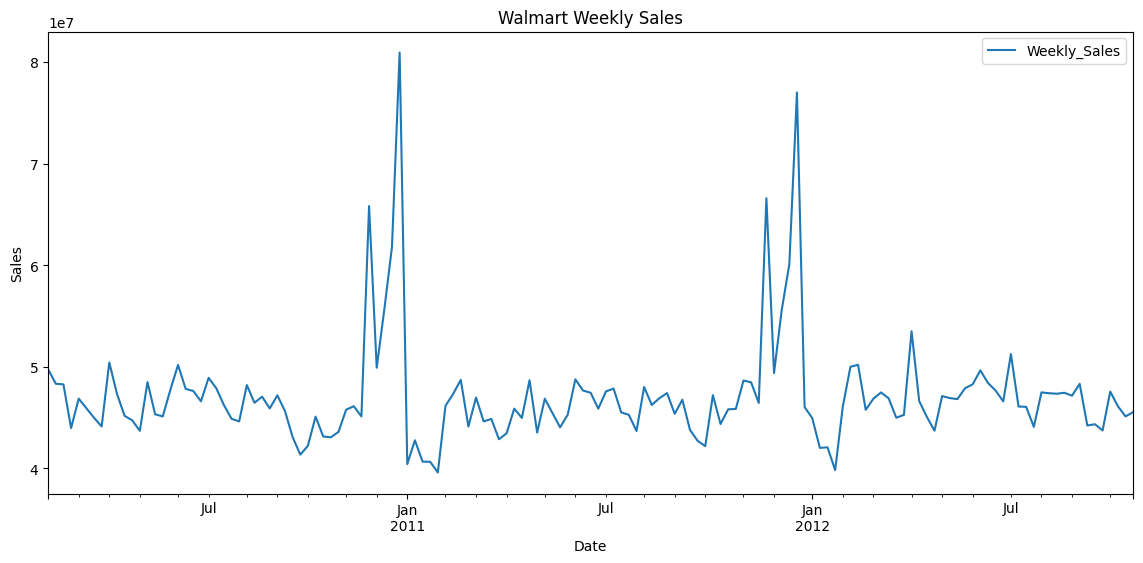

In [11]:
sales.plot(figsize=(14,6), title='Walmart Weekly Sales')
plt.ylabel('Sales');

---
## 🍀Error, Trend & Seasonality

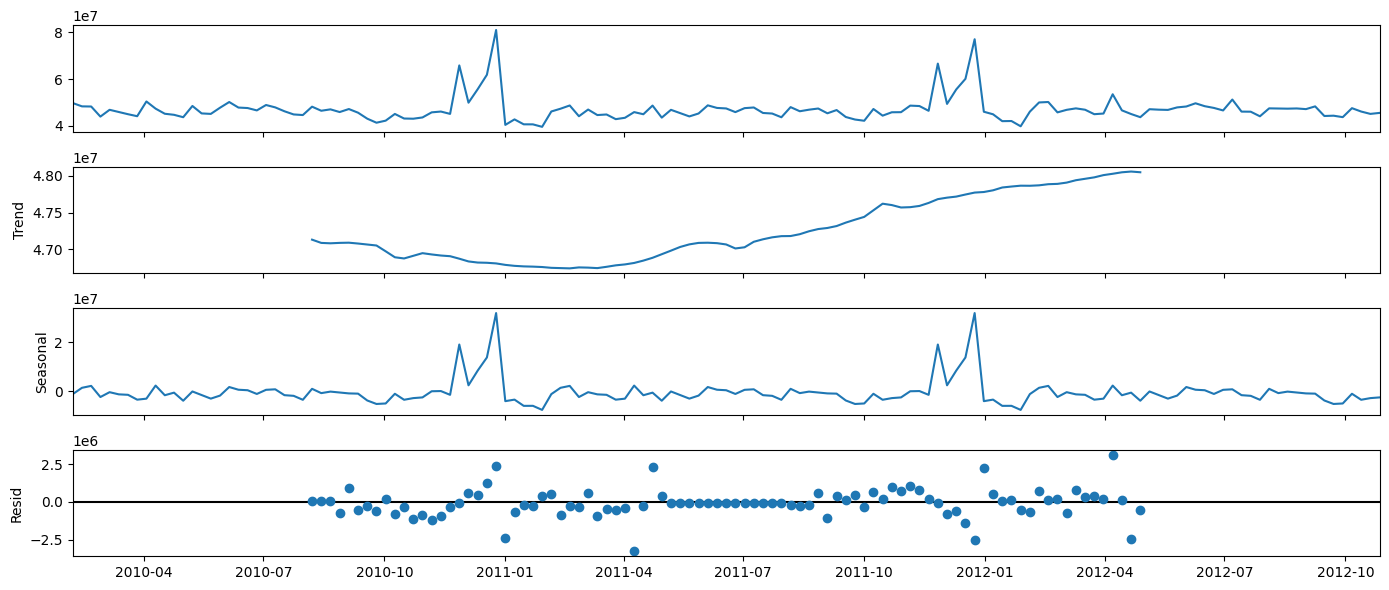

In [12]:
result = seasonal_decompose(sales)
rcParams['figure.figsize'] = 14,6
result.plot();

---
## 🍀Simple Moving Average (SWA)

In [13]:
sales['6-month-SWA'] = sales['Weekly_Sales'].rolling(window=6).mean()
sales['12-month-SWA'] = sales['Weekly_Sales'].rolling(window=12).mean()

## 🍀Exponential Moving Average (EWA)

In [14]:
sales['EWMA-12'] = sales['Weekly_Sales'].ewm(span=12).mean()

In [15]:
sales.dropna(inplace=True)

<Axes: xlabel='Date'>

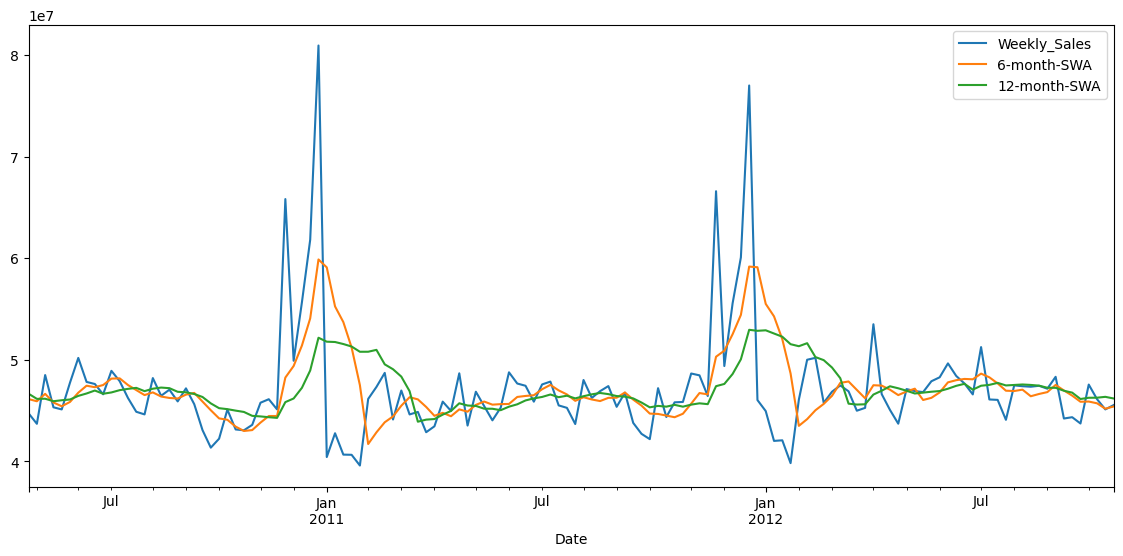

In [16]:
sales[['Weekly_Sales', '6-month-SWA', '12-month-SWA']].plot(figsize=(14,6))

<Axes: xlabel='Date'>

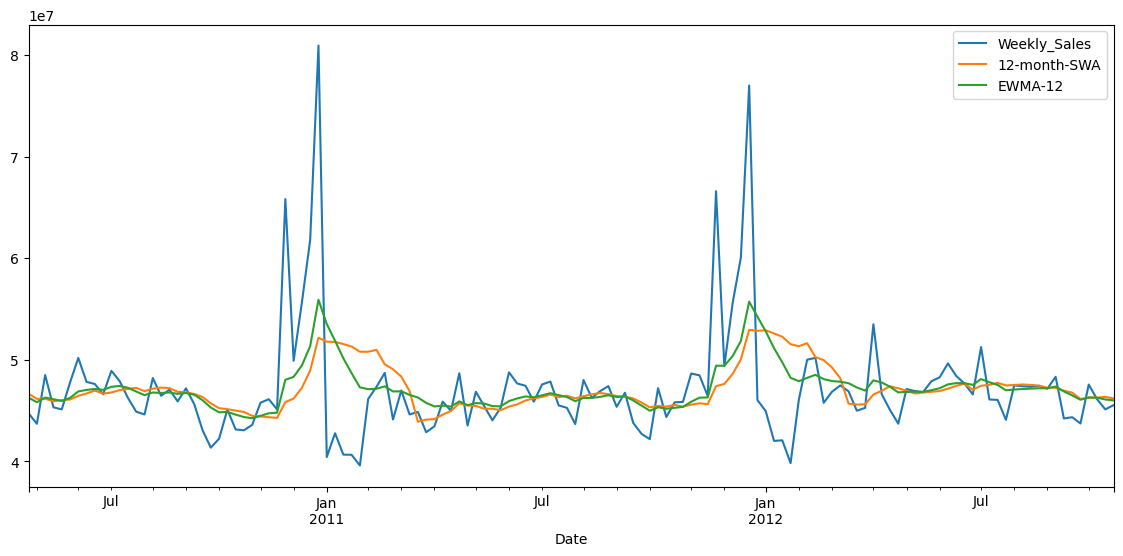

In [17]:
sales[['Weekly_Sales','12-month-SWA','EWMA-12']].plot()

In [18]:
sales.head()

,Weekly_Sales,6-month-SWA,12-month-SWA,EWMA-12
Date,,,,
2010-04-24,44734452.56,4.613836e+07,4.666334e+07,4.627713e+07
2010-05-01,43705126.71,4.592439e+07,4.615953e+07,4.583053e+07
2010-05-08,48503243.52,4.665260e+07,4.617341e+07,4.628561e+07
2010-05-15,45330080.20,4.580364e+07,4.592784e+07,4.612554e+07
2010-05-22,45120108.06,4.542945e+07,4.602380e+07,4.595939e+07


---
## 🍀Holt's Winter Method

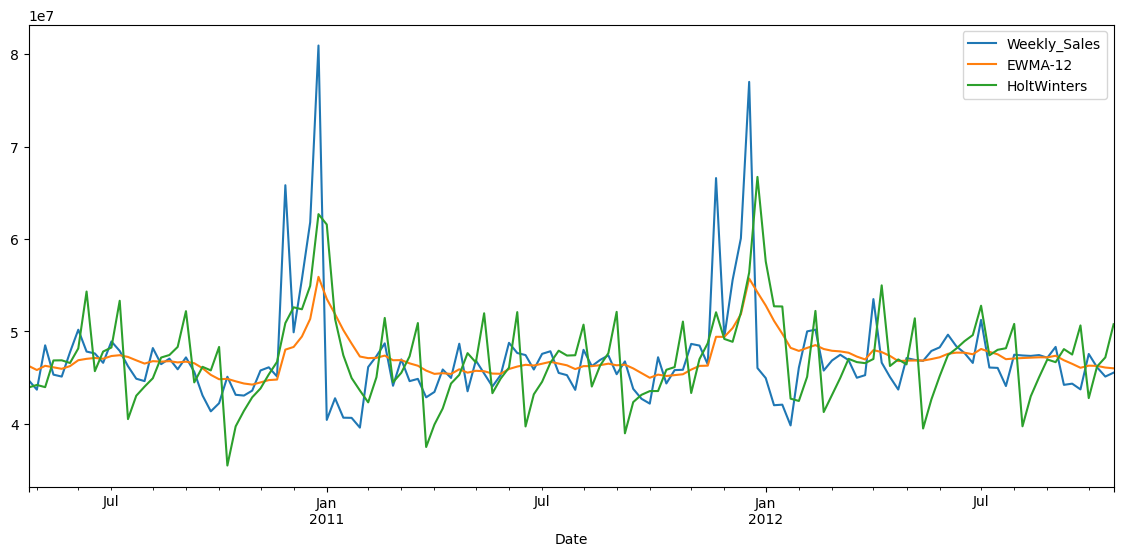

In [19]:
## Triple Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

sales['HoltWinters'] = ExponentialSmoothing(sales['Weekly_Sales'],
                                            trend='add',
                                            seasonal='add',
                                            seasonal_periods=12).fit().fittedvalues
sales[['Weekly_Sales', 'EWMA-12', 'HoltWinters']].plot(figsize=(14,6))
plt.show();

---
## 🍀Stationarity Test

In [20]:
sat=adf_test(sales['Weekly_Sales'], title='DFT')

Augmented Dickey-Fuller Test: DFT
ADF test statistic       -3.877766
p-value                   0.002205
# lags used              12.000000
# observations          119.000000
critical value (1%)      -3.486535
critical value (5%)      -2.886151
critical value (10%)     -2.579896
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


---
## 🍀ACF & PACF

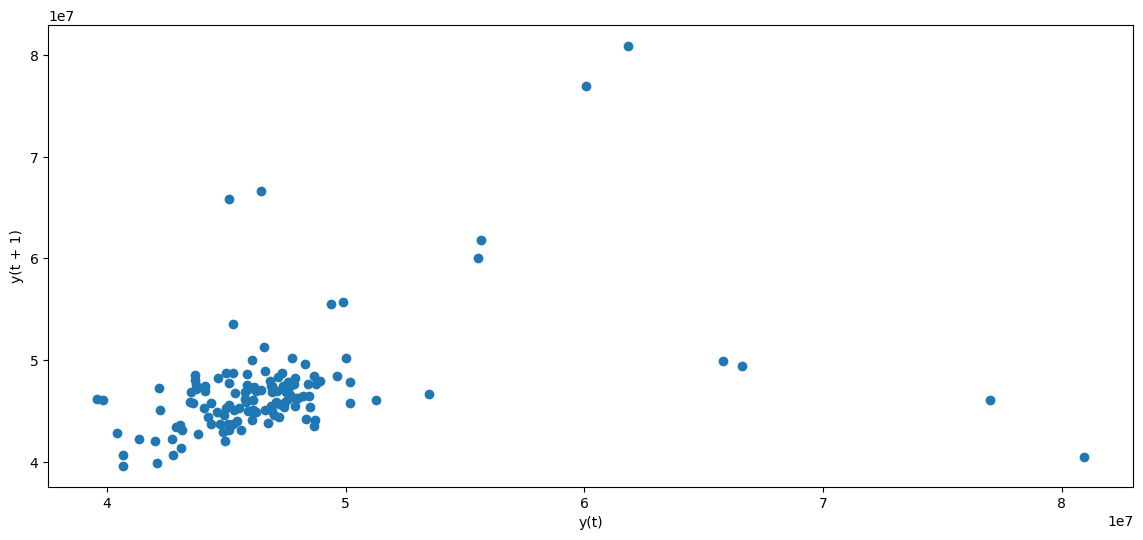

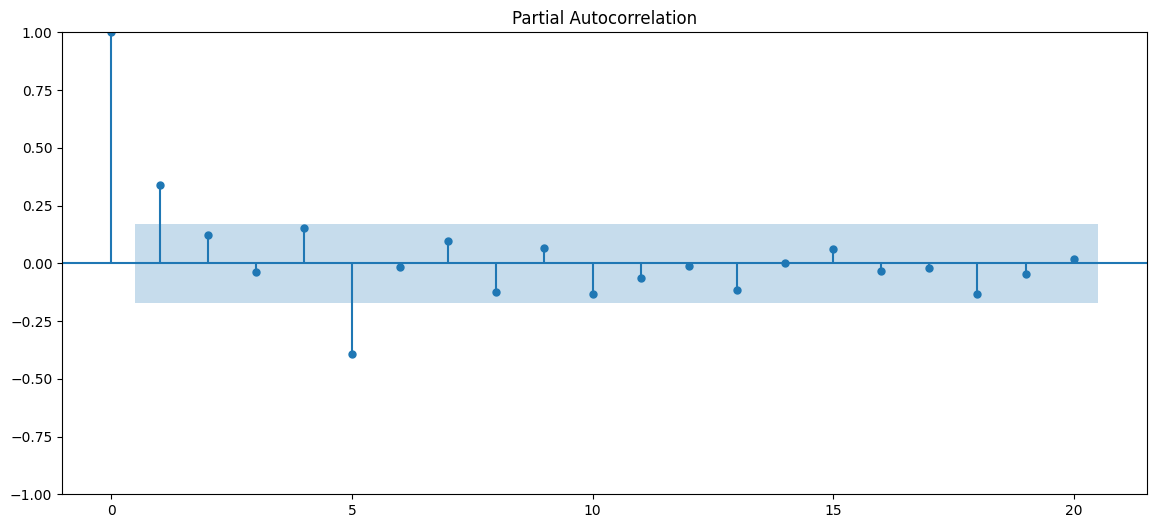

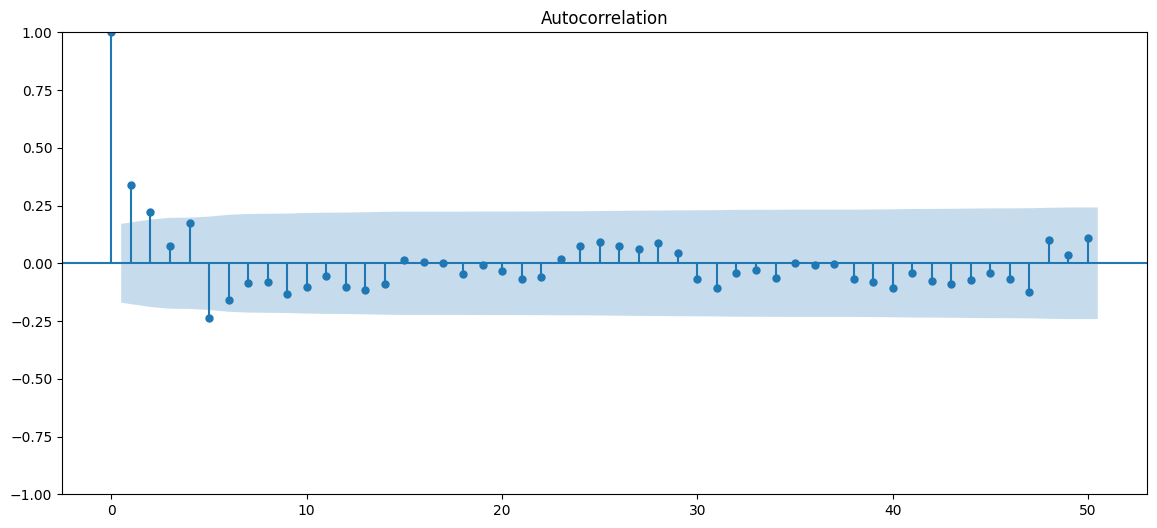

In [21]:
lag_plot(sales['Weekly_Sales'])
plot_pacf(sales['Weekly_Sales'],lags=20);
plot_acf(sales['Weekly_Sales'],lags=50);

In [22]:
data = df.copy()

p_values = range(3)
d_values = range(2)
q_values = range(3)

# Track the best AIC score
best_aic = float("inf")  
best_params = ()

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                # Fit ARIMA model for each combination of p, d, q values
                model = ARIMA(data, order=(p, d, q))
                results = model.fit()

                # Track the best parameters based on AIC score
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_params = (p, d, q)

            except Exception as e:
                print(f"Issue with (p, d, q) = ({p}, {d}, {q}): {str(e)}")
                continue

print("Best AIC:", best_aic)
print("Best (p, d, q) Parameters:", best_params)

Best AIC: 4814.786555597555
Best (p, d, q) Parameters: (2, 0, 2)


---
## 🍀ARIMA Model

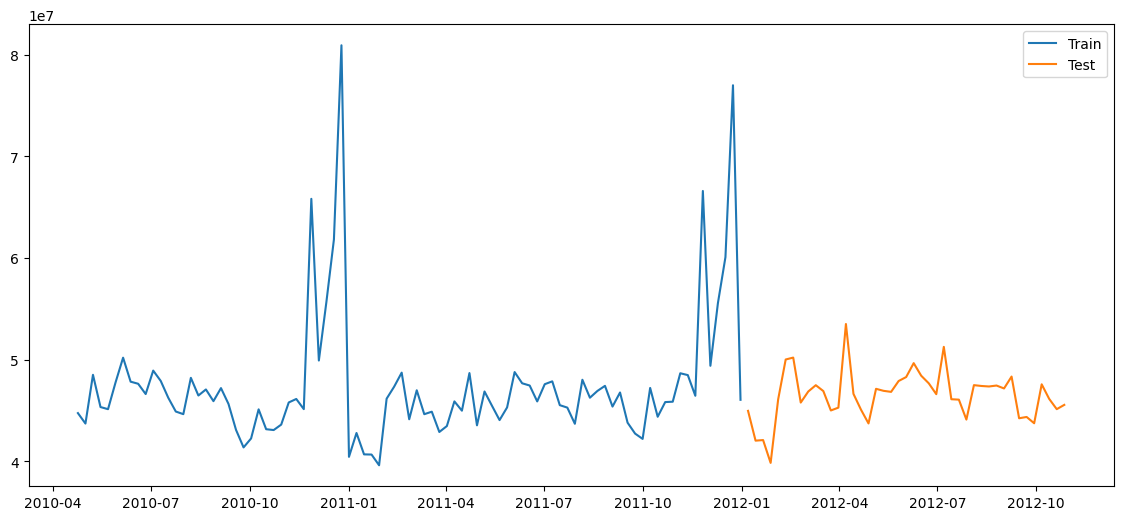

In [23]:
## Dividing the Data into Train, Test & Validation sets

train = sales[['Weekly_Sales']].loc['2010':'2011']
test = sales[['Weekly_Sales']].loc['2012']
plt.plot(train,label='Train')
plt.plot(test, label='Test')
plt.legend()

In [24]:
arima = auto_arima(train, d=1)
arima

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [25]:
p = 15
d = 0
q = 2

arima_mod = ARIMA(train['Weekly_Sales'],order=(p,d,q))
results = arima_mod.fit()

<Axes: xlabel='Date'>

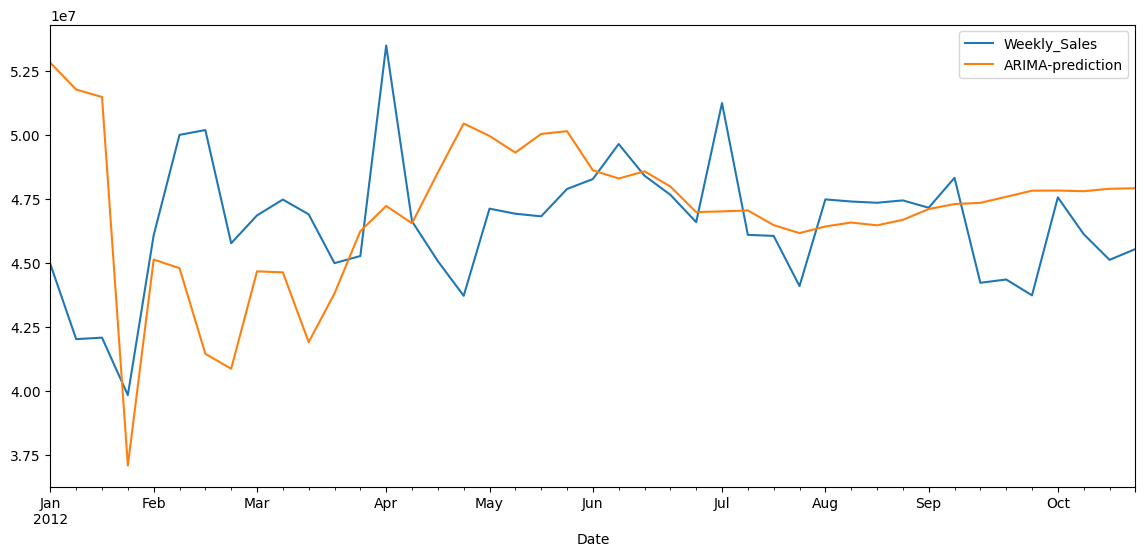

In [26]:
start = len(train)
end = len(train)+len(test)-1

predictions = results.predict(start=start,
                              end=end,
                              typ='levels').rename('ARIMA Predictions')
test['ARIMA-prediction'] = predictions
test.plot(figsize=(14,6))

---
## 🍀SARIMA

In [27]:
sarima_mod = SARIMAX(sales['Weekly_Sales'],
                order=(4,1,2),
                seasonal_order=(2,0,2,7),
                enforce_invertibility=False)
sarima_mod = sarima_mod.fit()

<Axes: xlabel='Date'>

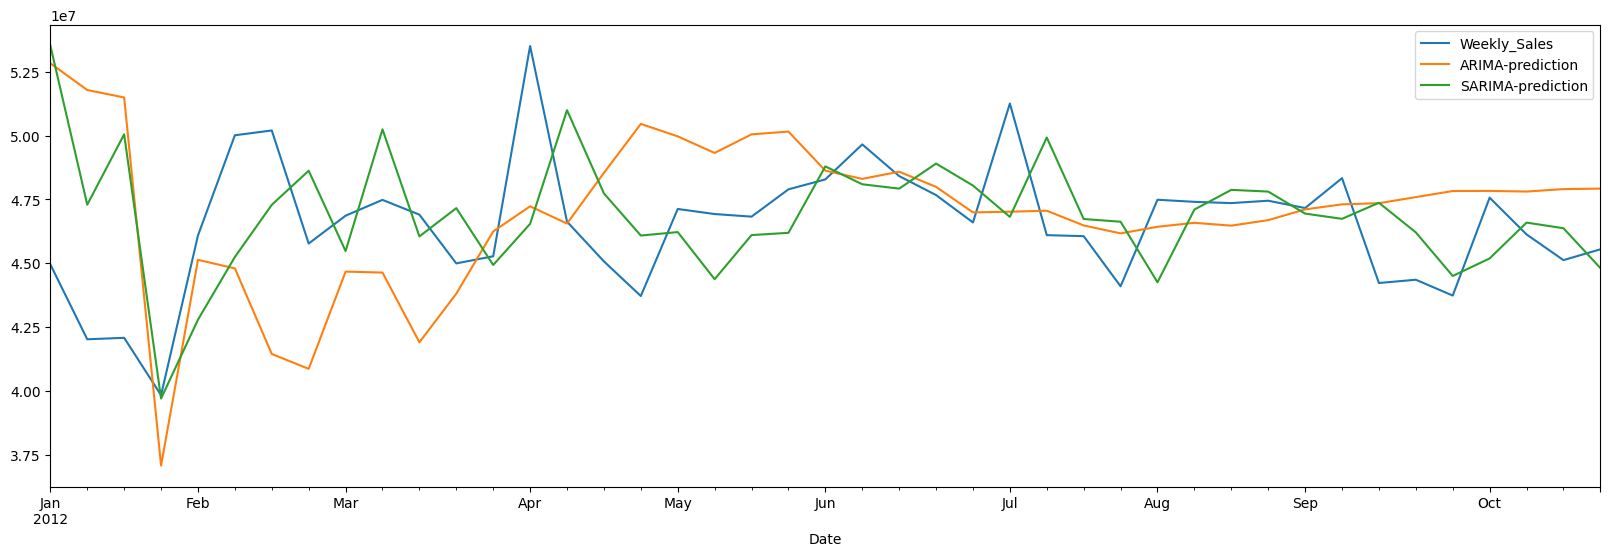

In [28]:
predictions = sarima_mod.predict(start=start,
                              end=end,
                              typ='levels').rename('SARIMA Predictions')
test['SARIMA-prediction'] = predictions

test.plot(figsize=(20,6))

---
## 🍀FBProphet

In [29]:
train.reset_index(inplace=True)

In [30]:
train.head()

,Date,Weekly_Sales
0,2010-04-24,44734452.56
1,2010-05-01,43705126.71
2,2010-05-08,48503243.52
3,2010-05-15,45330080.20
4,2010-05-22,45120108.06


In [31]:
train.columns = ['ds', 'y']
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      89 non-null     datetime64[ns]
 1   y       89 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.5 KB


22:47:07 - cmdstanpy - INFO - Chain [1] start processing
22:47:08 - cmdstanpy - INFO - Chain [1] done processing


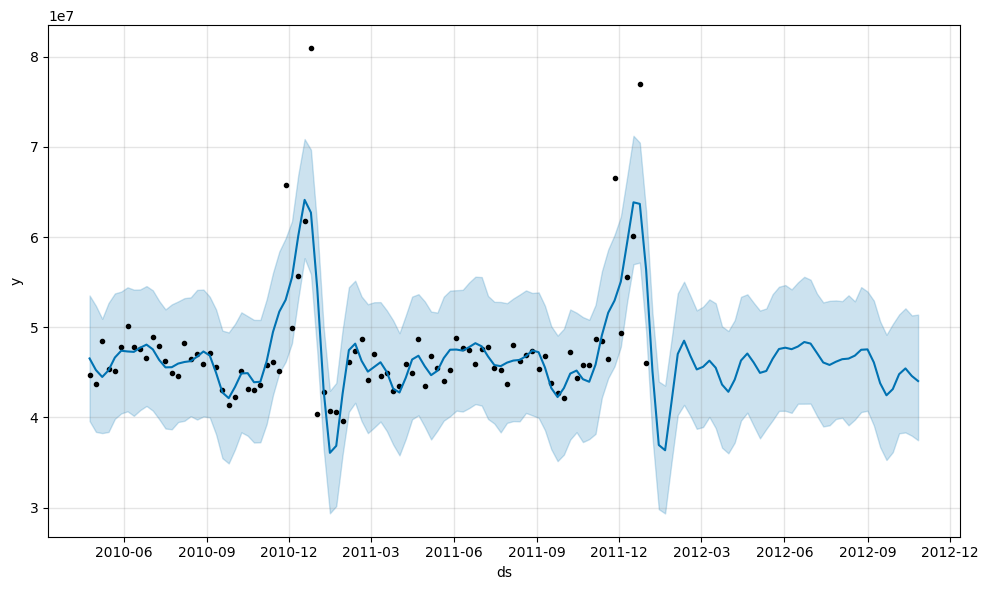

In [32]:
m = Prophet(yearly_seasonality=True,
            daily_seasonality=True,weekly_seasonality=True,
            holidays=calendar_holidays(),
            interval_width=0.9)
m.fit(train)

future = m.make_future_dataframe(periods=test.shape[0],freq='W-SAT',include_history=True)
forecast_entire = m.predict(future)
m.plot(forecast_entire);

forecast = forecast_entire[['ds','yhat']]
forecast.set_index(keys=['ds'], inplace=True)

In [33]:
forecast_entire

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),Christmas Day (Observed)_lower,Christmas Day (Observed)_upper,Columbus Day,Columbus Day_lower,Columbus Day_upper,Independence Day,Independence Day_lower,Independence Day_upper,Independence Day (Observed),Independence Day (Observed)_lower,Independence Day (Observed)_upper,Juneteenth National Independence Day,Juneteenth National Independence Day_lower,Juneteenth National Independence Day_upper,Juneteenth National Independence Day (Observed),Juneteenth National Independence Day (Observed)_lower,Juneteenth National Independence Day (Observed)_upper,Labor Day,Labor Day_lower,Labor Day_upper,Martin Luther King Jr. Day,Martin Luther King Jr. Day_lower,Martin Luther King Jr. Day_upper,Memorial Day,Memorial Day_lower,Memorial Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,New Year's Day (Observed),New Year's Day (Observed)_lower,New Year's Day (Observed)_upper,Thanksgiving,Thanksgiving_lower,Thanksgiving_upper,Veterans Day,Veterans Day_lower,Veterans Day_upper,Veterans Day (Observed),Veterans Day (Observed)_lower,Veterans Day (Observed)_upper,Washington's Birthday,Washington's Birthday_lower,Washington's Birthday_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-04-24,1.415369e+06,3.959522e+07,5.352380e+07,1.415369e+06,1.415369e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.512477e+07,4.512477e+07,4.512477e+07,2.592994e+07,2.592994e+07,2.592994e+07,0.0,0.0,0.0,1.944746e+07,1.944746e+07,1.944746e+07,-2.526267e+05,-2.526267e+05,-2.526267e+05,0.0,0.0,0.0,4.654014e+07
1,2010-05-01,1.418630e+06,3.839284e+07,5.238263e+07,1.418630e+06,1.418630e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.383612e+07,4.383612e+07,4.383612e+07,2.592994e+07,2.592994e+07,2.592994e+07,0.0,0.0,0.0,1.944746e+07,1.944746e+07,1.944746e+07,-1.541281e+06,-1.541281e+06,-1.541281e+06,0.0,0.0,0.0,4.525475e+07
2,2010-05-08,1.421891e+06,3.825701e+07,5.094059e+07,1.421891e+06,1.421891e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.306637e+07,4.306637e+07,4.306637e+07,2.592994e+07,2.592994e+07,2.592994e+07,0.0,0.0,0.0,1.944746e+07,1.944746e+07,1.944746e+07,-2.311024e+06,-2.311024e+06,-2.311024e+06,0.0,0.0,0.0,4.448826e+07
3,2010-05-15,1.425152e+06,3.838634e+07,5.269635e+07,1.425152e+06,1.425152e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.380359e+07,4.380359e+07,4.380359e+07,2.592994e+07,2.592994e+07,2.592994e+07,0.0,0.0,0.0,1.944746e+07,1.944746e+07,1.944746e+07,-1.573811e+06,-1.573811e+06,-1.573811e+06,0.0,0.0,0.0,4.522874e+07
4,2010-05-22,1.428412e+06,3.983863e+07,5.375205e+07,1.428412e+06,1.428412e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.521289e+07,4.521289e+07,4.521289e+07,2.592994e+07,2.592994e+07,2.592994e+07,0.0,0.0,0.0,1.944746e+07,1.944746e+07,1.944746e+07,-1.645132e+05,-1.645132e+05,-1.645132e+05,0.0,0.0,0.0,4.664130e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [34]:
test['Prophet'] = forecast.loc['2012-01':]

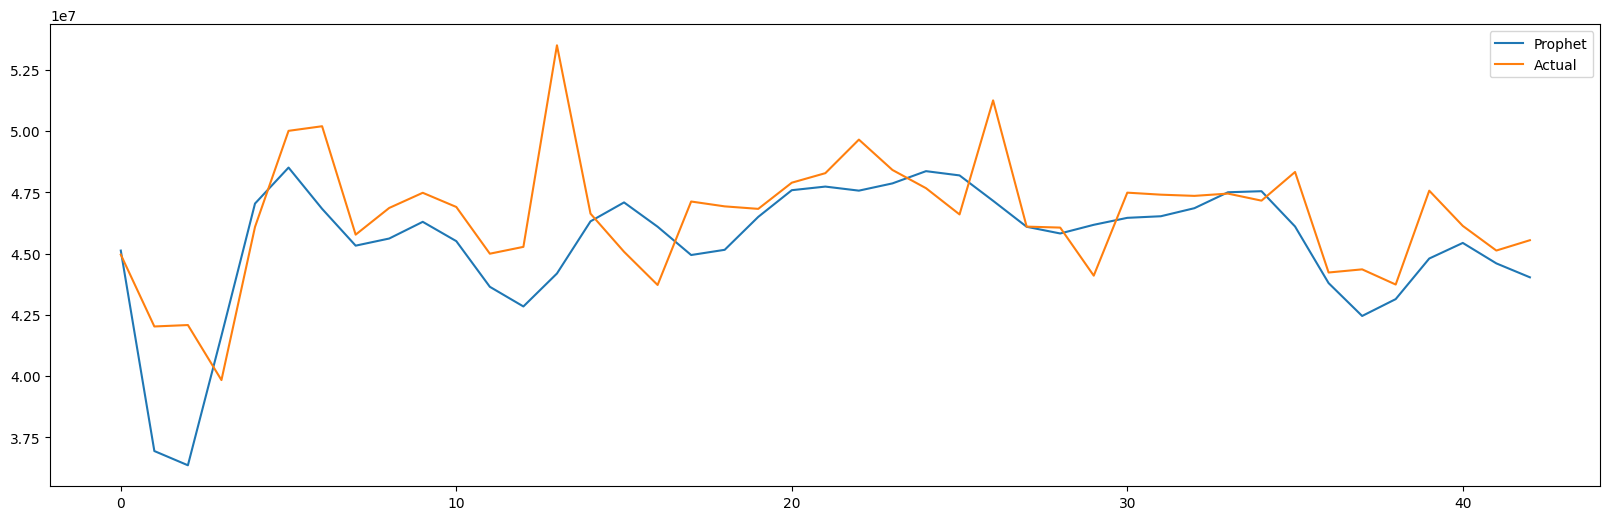

In [35]:
plt.figure(figsize=(20,6))
plt.plot(test['Prophet'].values, label='Prophet')
plt.plot(test['Weekly_Sales'].values, label='Actual')
plt.legend()
plt.show()

<Axes: xlabel='Date'>

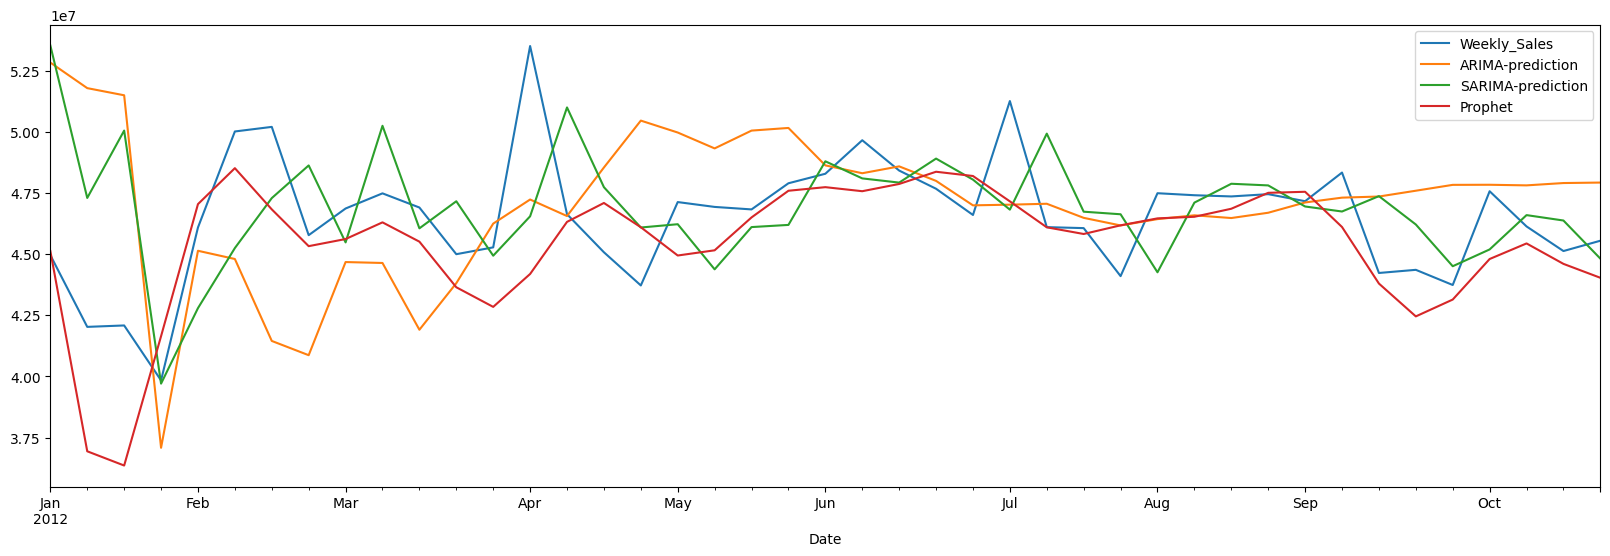

In [36]:
test.plot(figsize=(20,6))

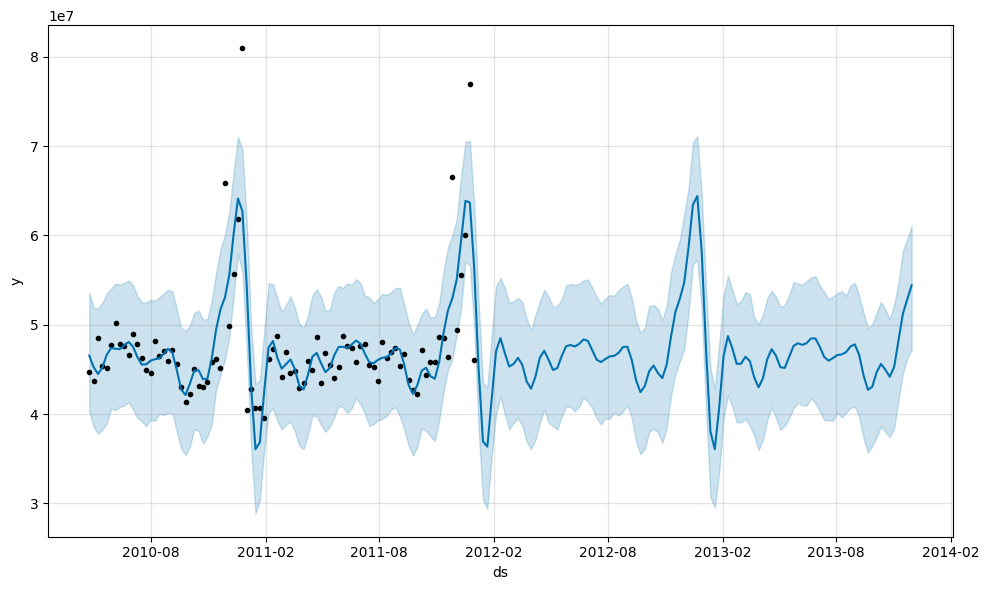

In [37]:
future_1=m.make_future_dataframe(periods=100,freq='W-SAT',include_history=True)
forecast_entire_1=m.predict(future_1)
m.plot(forecast_entire_1);

In [38]:
print('ARIMA-MAPE|MdAPE: %.2f|%.2f'%(mean_absolute_percentage_error(test['Weekly_Sales'], 
                                                              test['ARIMA-prediction']), 
                               MdAPE(test['Weekly_Sales'],
                                     test['ARIMA-prediction'])))

print('SARIMA-MAPE|MdAPE: %.2f|%.2f'%(mean_absolute_percentage_error(test['Weekly_Sales'], 
                                                              test['SARIMA-prediction']), 
                               MdAPE(test['Weekly_Sales'],
                                     test['SARIMA-prediction'])))

print('Prophet-MAPE|MdAPE: %.2f|%.2f'%(mean_absolute_percentage_error(test['Weekly_Sales'], 
                                                              test['Prophet']), 
                               MdAPE(test['Weekly_Sales'],
                                     test['Prophet'])))

ARIMA-MAPE|MdAPE: 6.15|4.72
SARIMA-MAPE|MdAPE: 4.96|3.55
Prophet-MAPE|MdAPE: 3.52|2.66
